# A2C Demo
This notebook focuses on training and testing the Advantage Actor-Critic (A2C) algorithm.

In [1]:
from a2c.agent import A2CAgent
from a2c.model import ACNetwork
from utils.wrappers import ResizeObservation, SkipFrame
from utils.config import Config
from utils.helper import get_primary_device
from utils.plotter import Plotter

import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from gym.wrappers import FrameStack, GrayScaleObservation
from nes_py.wrappers import JoypadSpace

import torch
import torch.optim as optim

D:\Users\Frazzle\anaconda3\envs\rla2\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
D:\Users\Frazzle\anaconda3\envs\rla2\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
# Set hyperparameters
ENV_NAME = 'SuperMarioBros-v3'

GAMMA = 0.99
LEARNING_RATE = 0.001
EPSILON = 1e-3
ENTROPY_WEIGHT = 0.01
VALUE_LOSS_WEIGHT = 1.0

N_STEPS = 10 # TD bootstrapping
GRAD_CLIP = 0.1 # Prevents gradients from being too large
NUM_EPISODES = 2000

# Create environment
env = gym_super_mario_bros.make(ENV_NAME)
env = JoypadSpace(env, SIMPLE_MOVEMENT)

# Apply wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env, keep_dim=False) # Grayscale images
env = ResizeObservation(env, shape=84) # image dim: [84, 84]
env = FrameStack(env, num_stack=4) # 4 frames at a time

# Set config instance
config = Config(env=env, env_name=ENV_NAME)

# Create network and optimizer
network = ACNetwork(config.input_shape, config.n_actions)
optimizer = optim.Adam(network.parameters(), lr=LEARNING_RATE, eps=EPSILON)

# Add hyperparameters to config
config.add(
    discount=GAMMA,
    entropy_weight=ENTROPY_WEIGHT,
    value_loss_weight=VALUE_LOSS_WEIGHT,
    rollout_size=N_STEPS,
    grad_clip=GRAD_CLIP,
    num_episodes=NUM_EPISODES,
    network=network,
    optimizer=optimizer
)

In [3]:
# https://github.com/Kautenja/gym-super-mario-bros/blob/master/gym_super_mario_bros/actions.py
print('Available actions:', config.action_space)
print('Obs space shape: ', config.input_shape)

Available actions: Discrete(7)
Obs space shape:  (4, 84, 84)


# Training
This section focus on training the agent.

In [5]:
# Train agent
agent.tuning(config=config, rollout_sizes=[2], print_every=100, save_count=1000)

Running training with rollout length 2 on 2000 episodes.
(1/2K) Episode avg return: -0.033	Episode total loss: -0.015	Accumulated batch total avg return: -0.033
(100/2K) Episode avg return: 64.981	Episode total loss: 0.333	Accumulated batch total avg return: 3290.875
(200/2K) Episode avg return: 67.050	Episode total loss: 0.057	Accumulated batch total avg return: 9937.418
(300/2K) Episode avg return: 65.894	Episode total loss: 0.055	Accumulated batch total avg return: 16579.330
(400/2K) Episode avg return: 67.828	Episode total loss: 0.058	Accumulated batch total avg return: 23273.279
(500/2K) Episode avg return: 66.035	Episode total loss: 0.055	Accumulated batch total avg return: 29968.782
(600/2K) Episode avg return: 65.775	Episode total loss: 0.055	Accumulated batch total avg return: 36632.279
(700/2K) Episode avg return: 67.798	Episode total loss: 0.058	Accumulated batch total avg return: 43290.924
(800/2K) Episode avg return: 68.130	Episode total loss: 0.059	Accumulated batch total

## Testing
This section focuses on testing and analysing the models performance.

In [4]:
filename = 'r10/a2c_rollout10_ep200k'

# Get device name
device_count = torch.cuda.device_count()
device = get_primary_device(count=device_count)

# Create agent instance
agent = A2CAgent(config=config, device=device)

# Load pretrained model
agent.load_model(filename=filename, device=device)

Single CUDA device available. Device set to GPU.
Loaded A2C model: 'r10/a2c_rollout10_ep200k'.


In [5]:
# Create plotter
vis = Plotter(logger=agent.logger)

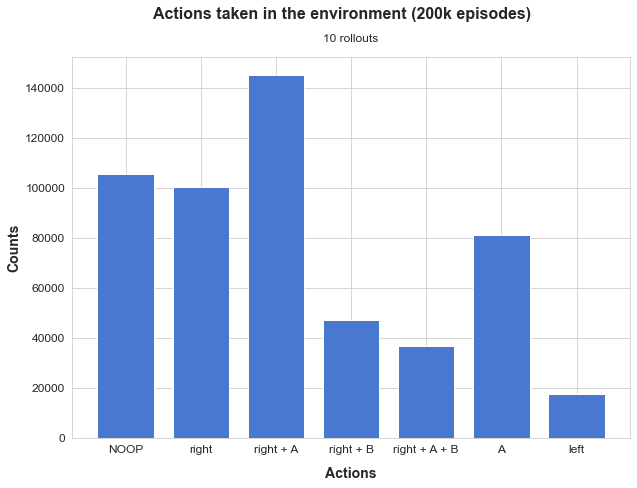

In [6]:
vis.actions_chart(data=agent.logger.actions, subplot_title='10 rollouts', figsize=(10, 7), width=0.75)

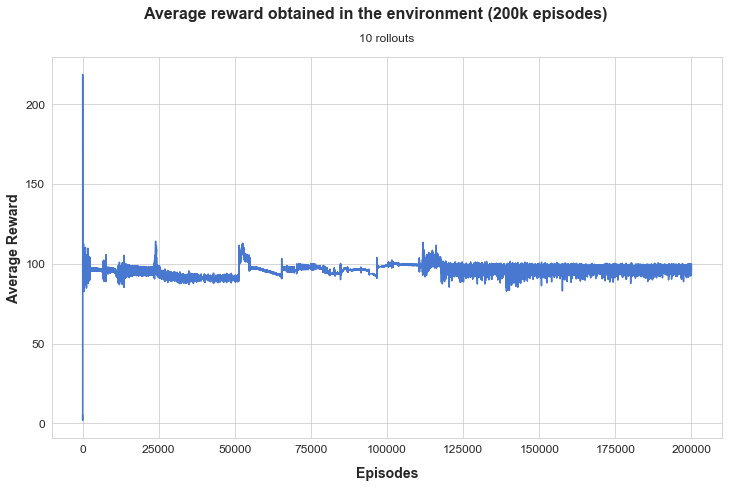

In [7]:
vis.rewards_plot(data=agent.logger.avg_returns, subplot_title='10 rollouts', figsize=(12, 7))

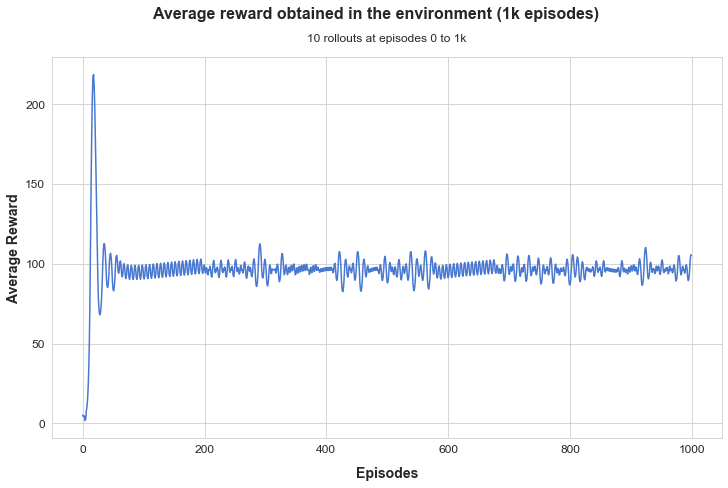

In [8]:
vis.rewards_plot(data=agent.logger.avg_returns[:1000], subplot_title='10 rollouts at episodes 0 to 1k', figsize=(12, 7))

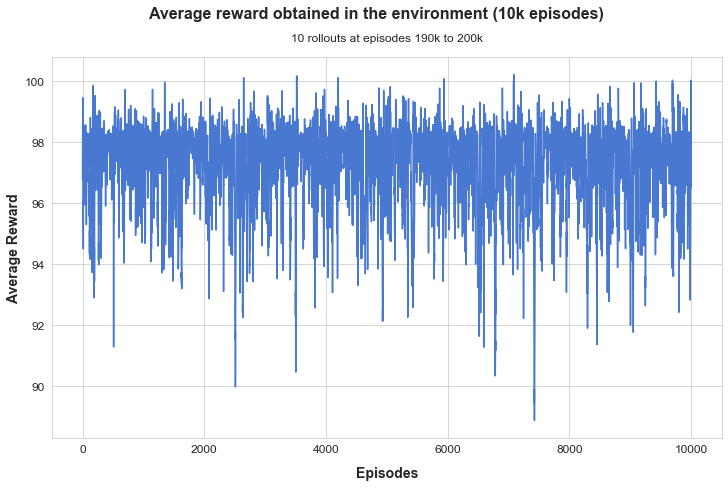

In [9]:
vis.rewards_plot(data=agent.logger.avg_returns[190000:], subplot_title='10 rollouts at episodes 190k to 200k', figsize=(12, 7))

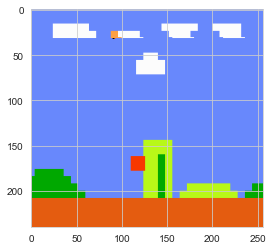

In [11]:
# Select method for watching the agent play the environment
# vis.video_render(env=env, agent=agent, steps=3000)
vis.plot_render(env=env, agent=agent, steps=3000)